In [8]:
import time
import math
import pyaudio
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import RPi.GPIO as GPIO
import spiUtils as su

### pyAudio functions

In [9]:
#class for writing to speaker
class Output:
    pa = None;
    s  = None;
    #call this function to open output and create stream
    def __init__(self,rate=8000):
        """
        Output class constructor initializes and opens pyAudio output
        stream. Allows sending audio data to an audio output device via python.
        """
        #print ("init_audio: Create PyAudio object")
        self.pa = pyaudio.PyAudio()
        #print ("init_audio: Open stream")
        self.s = self.pa.open(output=True,
                channels=1,
                rate=rate,
                format=pyaudio.paInt16,
                output_device_index=0)
        print ("audio stream initialized")

    def close_audio(self):
        """
        Output class destructor closes and destructs output object
        and associated pyAudio stream.
        """
        #print ("close_audio: Closing stream")
        self.s.close()
        print ("close_audio: Terminating PyAudio Object")
        self.pa.terminate()
        
    #create a numpy array of a given freqeuncy    
    def note(self, freq, len, amp=5000, rate=8000, 
            vibrato=0,vibratoFreq=0):
        """
        Creates a uniform note (a sinusoidal waveform of with characteristics specified
        by function parameters) returned as a 16bit integer numpy array.
        """
        t = np.linspace(0,len,len*rate)
        freq_data= (freq + vibrato*np.sin(2*np.pi*t*vibratoFreq))
        data = np.sin(2*np.pi*(freq + vibrato*np.sin(2*np.pi*t*vibratoFreq))*t)*amp
        plt.plot(freq_data)
        #np.savetxt('test.out', freq)
        return data.astype(np.int16) # two byte integers
    
    
    #write numpy array to stream
    def tone(self, note):
        """
        Takes a 16bit integer numpy array, representing a note, as an argument
        and plays the represented note via the pyAudio stream.
        """
        # generate sound
        self.s.write(note)
    
    #add two numpy arrays together
    def add_note(self, note1, note2):
        """
        combines two notes (of the same length) element-wise to produce a new note.
        """
        return note1 + note2
    
    

### signal processing functions

In [10]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def interp_upsamp(data, SAMP_DURATION=10, MAG_SCALAR=1):
    """
    Uses linear interpolation to upsample numpy arrays to a uniform shape
    to accomodate the pyAudio stream parameters.
    """
    SAMP_DURATION = float(SAMP_DURATION) # seconds
    data_len = len(data)
    fs = data_len / SAMP_DURATION
    xp = np.arange(data_len)
    x = np.linspace(0, data_len, 8000*int(SAMP_DURATION))
    upsamp_data = np.interp(x, xp, data) * MAG_SCALAR
    return upsamp_data

### tone library

In [11]:
keys = {
    "c4": 261.63,
    "d4": 293.66,
    "e4": 329.63,
    "f4": 349.23,
    "g4": 392,
    "a4": 440,
    "b4": 493.88,
    "c5": 523.25
}

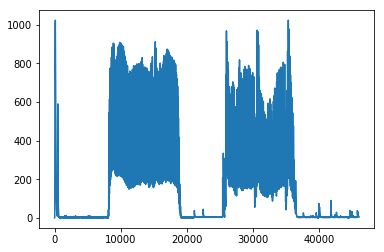

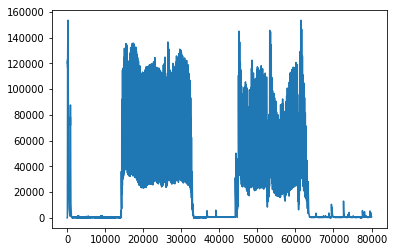

80000
audio stream initialized
start playing tones
Interrupt!
Done!
close_audio: Terminating PyAudio Object


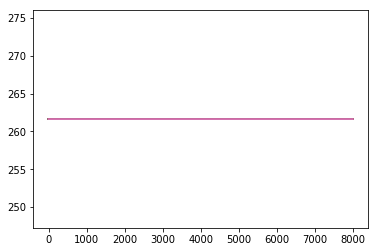

In [7]:


#this is all kinda random stuff
try:
        
    data = np.load("dig22Apr19.npy")

    upsamp_data = interp_upsamp(data, SAMP_DURATION=10, MAG_SCALAR=150)
    
    plt.plot(data)
    plt.show()
    plt.plot(upsamp_data)
    plt.show()
    
    print(len(upsamp_data))
    #up_samp = 150 * up_samp
    filtered_data = butter_lowpass_filter(upsamp_data, 200,8000, 5)
    aO = Output()
      # play tones forever    
    print( "start playing tones")
    while True:
        
        aO.tone(upsamp_data.astype(np.int16))
        time.sleep(.5)
        aO.tone(aO.note(keys['c4'], 1))
        
        #c1 = aO.note
        #aO.tone(aO.note(keys['d4'], 1))
        #aO.tone(aO.note(keys['e4'], 1))
        #aO.tone(aO.note(keys['f4'], 1))
        #aO.tone(aO.note(keys['g4'], 1))
        #aO.tone(aO.note(keys['a4'], 1))
        #aO.tone(aO.note(keys['b4'], 1))
        #aO.tone(aO.note(keys['c5'], 1))
        #time.sleep(1)
        #aO.tone(aO.note(100, 10, vibrato=10,vibratoFreq=5))
        #aO.tone(aO.note(keys['c4'], 1))
        #aO.tone(aO.note(keys['c4'], 5, vibrato=.5,vibratoFreq=5000))
        
        
except(KeyboardInterrupt, SystemExit):
    print("Interrupt!")

finally:
    print("Done!")
    aO.close_audio();           
         

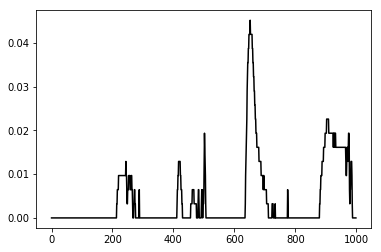

Done!
close_audio: Terminating PyAudio Object


In [17]:


try:
    # This n value takes a few seconds to run so you can test
    nDATA  = 1000
    #toVolt = 3.3/1023
    dPIEZO = np.zeros(nDATA,dtype='float')

        
    plt.plot(dPIEZO,'k');
    plt.show()    
   
    #while True:
    # get a packet of data from the piezo
    for i in range(nDATA):
        #dPIEZO[i] = toVolt * su.readADC(channel=0) # PIEZO element
        dPIEZO[i] = su.readADC(channel=0) # PIEZO element
    
    # if the data has a signature of the resonating digeridoo
    if np.amax(dPiezo) > .02:
        # collect all of the potentiometer values
        
        # generate an output signal
        
        # play the output signal
        
    # otherwise, continue
        
except(KeyboardInterrupt, SystemExit):
    print("Interrupt!")

finally:
    print("Done!")
    aO.close_audio();           